In [40]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as scistats
import torch
import torch.nn as nn
from GMM import gaussian_mixture_models
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import copy
import scipy.stats as scistats
%matplotlib inline

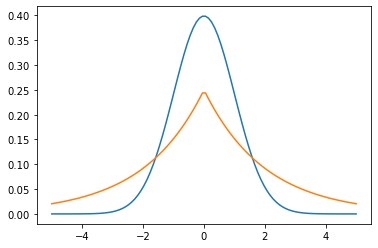

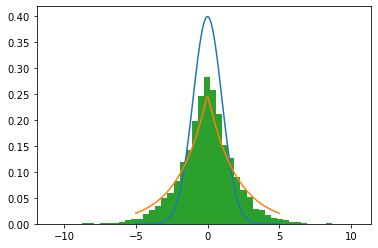

In [68]:
gauss = scistats.norm(0, 1)
laplace = scistats.laplace(0, 2)
interpolate = lambda alpha, v: (1 - alpha) * gauss.ppf(v) + (alpha) * laplace.ppf(v)
    
x_range = np.linspace(-5, 5, 100)

plt.figure()
plt.plot(x_range, gauss.pdf(x_range))
plt.plot(x_range, laplace.pdf(x_range))
plt.show()


x_new = []
alpha = 0.5

#Randomly sample
for i in range(10000):
    v = np.random.random()
    x_new.append(interpolate(alpha, v))

plt.figure()
plt.plot(x_range, gauss.pdf(x_range))
plt.plot(x_range, laplace.pdf(x_range))
plt.hist(x_new, bins = 50, density = True)
plt.show()

# Create a heteroscedastic dataset

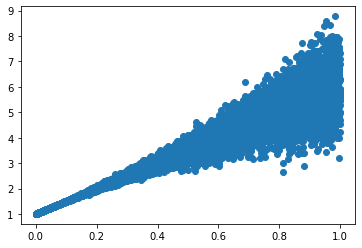

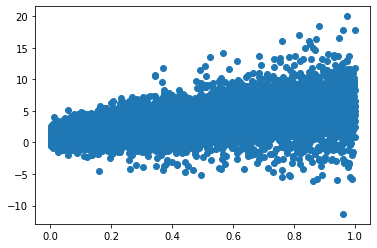

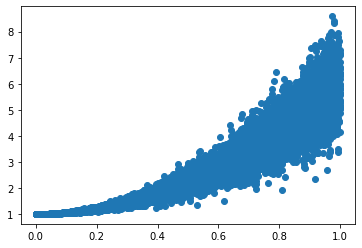

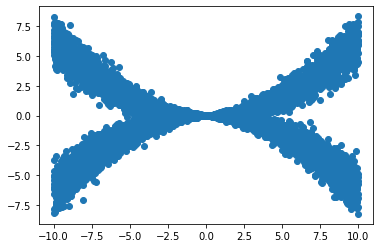

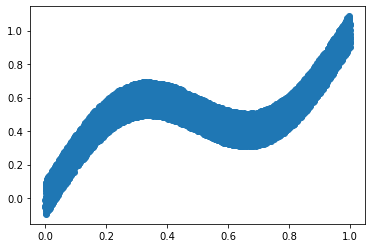

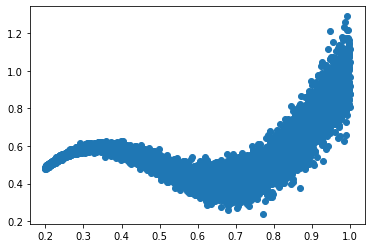

In [69]:
def linear_sampler(n_samples, m = 5, c = 1, x_range = [0, 1]):
    
    x_n = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    y_n = x_n * m + c 
    noise = np.random.randn(n_samples)
    heteroscedacity = x_n**2 * noise
    
    return x_n, y_n + heteroscedacity

def linear_shift_sampler(n_samples, m = 5, c = 1, x_range = [0, 1]):
    
    gauss = scistats.norm(0, 1)
    laplace = scistats.laplace(0, 2)
    interpolate = lambda alpha, v: (1 - alpha) * gauss.ppf(v) + (alpha) * laplace.ppf(v)
    
    x_n = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    y_n = x_n * m + c 
    noise = np.zeros(n_samples)
    
    #Randomly sample, x acts as alpha
    for i in range(n_samples): 
        v = np.random.random() #Sample the v value
        noise[i] = interpolate(x_n[i], v)
    
    heteroscedacity = noise# * (x_n + 1)
    
    return x_n, y_n + heteroscedacity

def quadratic_sampler(n_samples, m = 5, c = 1, x_range = [0, 1]):
    
    x_n = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    y_n = x_n**2 * m + c 
    noise = np.random.randn(n_samples)
    heteroscedacity = x_n**2 * noise
    
    return x_n, y_n + heteroscedacity

def squared_sampler(n_samples, sigma = 0.1):
    
    binary_sampler = np.random.randint(0, 2, n_samples)

    sign = -1 * (binary_sampler == 0) + 1 * (binary_sampler == 1)

    x_n = np.random.uniform(-10, 10, n_samples)
    
    noise = np.abs(x_n) * np.random.randn(n_samples) * sigma
    y_n = sign * (x_n/4)**2 + noise
    
    return x_n, y_n

def bishop_sampler(n_samples):
    
    x_n = np.random.uniform(0, 1, n_samples)
    
    y_n = x_n + 0.3 * np.sin(2 * np.pi * x_n)
    noise = np.random.uniform(-0.1, 0.1, n_samples)
    
    return x_n, y_n + noise

def bishop_sampler_2(n_samples, sigma = 0.1):
    
    x_n = np.random.uniform(0.2, 1, n_samples)
    
    y_n = x_n + 0.3 * np.sin(2 * np.pi * x_n)
    noise = np.random.randn(n_samples) * np.abs(x_n)**2 * sigma
    
    return x_n, y_n + noise

#linear data
x, y = linear_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#linear (noise shifted) data
x, y = linear_shift_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#quadratic data
x, y = quadratic_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#Squared data
x, y = squared_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#Bishop data
x, y = bishop_sampler(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

#Bishop 2 data
x, y = bishop_sampler_2(10000)

plt.figure()
plt.scatter(x, y)
plt.show()

# Mixture Density Network

In [35]:
class mu_layer(nn.Module):
    """
    Purpose of this is to allow the user to initialise the bias of the network by adding a nn.Parameter that the user can control.
    
    This nn.Parameter module is additive to the network output.
    """
    def __init__(self, n_out_features, n_hidden, n_components, initial_params = None, bias_flag = None):
        super(mu_layer, self).__init__()
        
        self.n_out_features = n_out_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.initial_params = initial_params
        self.bias_flag = bias_flag #Allows explicit control, useful for when you have a polynomial regression model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.initial_params is not None:
            assert self.initial_params.shape[0] == self.n_components, print("The initialisation tensor shape is incorrect in the mu_layer module.")

            self.bias = nn.Parameter(torch.from_numpy(self.initial_params.reshape(1, -1).astype(np.float32)), requires_grad = True)
            
            if self.bias_flag is None:
                self.bias_flag = False
            
        else:
            self.bias = nn.Parameter(torch.zeros(1, int(self.n_components * self.n_out_features)), requires_grad = False)
            
            if self.bias_flag is None:
                self.bias_flag = True
            
        self.mu_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components * self.n_out_features),
                                 bias = bias_flag)
         
    def forward(self, hidden_representation):
        
        return self.mu_net(hidden_representation) + self.bias

class sigma_layer(nn.Module):
    
    def __init__(self, n_out_features, n_hidden, n_components, initial_params = None, bias_flag = None):
        super(sigma_layer, self).__init__()
        
        self.n_out_features = n_out_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.initial_params = initial_params
        self.bias_flag = bias_flag #Allows explicit control, useful for when you have a polynomial regression model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.activation = nn.Softplus()#lambda x: self._activation(x) + 1 + self.eps
        self.eps = 1e-8
        
        if self.initial_params is not None:
            assert self.initial_params.shape[0] == self.n_components, print("The initialisation tensor shape is incorrect in the mu_layer module.")
            
            #Need to adjust the bias to undo the softplus activation
            self.initial_params = np.log(np.exp(self.activation.beta * self.initial_params) - 1) / self.activation.beta
            
            #Need to adjust zero values
            #self.initial_params = initial_params * (initial_params > 0)
            
            self.bias = nn.Parameter(torch.from_numpy(self.initial_params.reshape(1, -1).astype(np.float32)), requires_grad = True)
            
            if self.bias_flag is None:
                self.bias_flag = False
            
        else:
            self.bias = nn.Parameter(torch.zeros(1, int(self.n_components * self.n_out_features)), requires_grad = False)
            
            if self.bias_flag is None:
                self.bias_flag = True
            
        self.sigma_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components * self.n_out_features),
                                 bias = bias_flag)
    
    def forward(self, hidden_representation):
        
        return self.activation(self.sigma_net(hidden_representation) + self.bias) + self.eps

class pi_layer(nn.Module):
    
    def __init__(self, n_out_features, n_hidden, n_components, bias_flag = False):
        super(pi_layer, self).__init__()
        
        self.n_out_features = n_out_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.bias_flag = bias_flag #Allows explicit control, useful for when you have a polynomial regression model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.activation = nn.Softmax(dim = 1)
            
        self.pi_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components),
                                 bias = self.bias_flag)
        
        self.eps = 1e-8
         
    def forward(self, hidden_representation):
        
        return self.activation(self.pi_net(hidden_representation)) + self.eps #Bias does nothing, I am not sure how to initialise this well initially.
    
class feature_transform_object(object):
    
    def __init__(self, n_features, M = 1, transform_flag = False):
        """
        M = polynomial order
        """
        
        self.n_features = n_features
        self.M = M
        self.activate_transform = transform_flag
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.n_features > 1 and self.activate_transform:
            print("Feature transformer is not optimised for n_features > 1.")
            raise SystemExit
    
    def feature_transform(self, x):
        
        if self.activate_transform:
            
            x = x.detach().cpu().numpy()
            
            scale_terms = np.arange(0, self.M + 1, 1).reshape(1, -1) #M + 1 terms
            
            transform = x.reshape(-1, self.n_features)**scale_terms
            
            return torch.from_numpy(transform.astype(np.float32)).to(self.device)
        
        else:
            return x

class MixtureDensityNetwork(nn.Module):
    
    def __init__(self, n_features, n_outputs, n_components, regression_type = 'polynomial', net_dict = None, init_params = None, lambda_batch = 1, vectorise = True):
        """
        This implementation is for a N-dimensional Mixture density network. I emphasise here that it is N-dimensional as I 
        try to improve the code to have better initialisations and a well-trained behaviour. 
        
        regression_type = polynomial or network
        """
        super(MixtureDensityNetwork, self).__init__()
        
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.n_components = n_components
        self.regression_type = regression_type
        self.net_dict = net_dict
        self.init_params = init_params
        self.lambda_batch = lambda_batch
        self.vectorise = vectorise
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Define the hidden network activation function
        self.activation = nn.Tanh()
        
        if self.regression_type.lower() == "polynomial":
            
            try:
                assert self.net_dict["M"] is not None
                
            except AssertionError:
                print("You have specified that the model is a {}, but M is None.".format(self.regression_type))
                print("\n", self.net_dict)
                
                raise SystemExit
            
            else:
                self.M = self.net_dict["M"]
                self.activate_transform = True
                
        elif self.regression_type.lower() == "network":
            self.M = 1
            self.activate_transform = False
            
        
        else:
            print("Unknown regression_type entered ({}).".format(self.regression_type))
            raise SystemExit
            
        #Initialise transformer
        self.transform = feature_transform_object(self.n_features, self.M, self.activate_transform)
        
        #Initialise the model
        self.initialise_model()
        
        #Initialise the optimiser
        self.initialise_optimiser()
    
    ###############################
    #MODEL INITIALISATION FUNCTIONS
    ###############################
    def initialise_model(self):
        
        if self.regression_type.lower() == "polynomial":
            
            self.hidden_net = self.transform.feature_transform
            
            self.mu_net = mu_layer(self.n_outputs, 
                                   self.M + 1,
                                   self.n_components,
                                   initial_params = None,
                                   bias_flag = False)
            
            self.sigma_net = sigma_layer(self.n_outputs, 
                                      self.M + 1,
                                      self.n_components,
                                      initial_params = None,
                                      bias_flag = False)
            
            self.pi_net = pi_layer(self.n_outputs,
                                  self.M + 1,
                                  self.n_components,
                                  bias_flag = False)
        
        else:
            
            hidden_layers = []
            
            n_layers = len(self.net_dict["ff_layers"]) -1
            
            for cnt in range(n_layers):
                
                    hidden_layers.append(nn.Linear(in_features = self.net_dict["ff_layers"][cnt], 
                                                out_features = self.net_dict["ff_layers"][cnt + 1], bias = True))
                    
                    hidden_layers.append(self.activation)
            
            self.hidden_net = nn.Sequential(*hidden_layers)
            
            #Check for initial parameters
            self.initialise_parameters()
            
            self.mu_net = mu_layer(self.n_outputs, 
                                   self.net_dict["ff_layers"][-1],
                                   self.n_components,
                                   initial_params = self.initial_params[0],
                                   bias_flag = None)
            
            self.sigma_net = sigma_layer(self.n_outputs, 
                                      self.net_dict["ff_layers"][-1],
                                      self.n_components,
                                      initial_params = self.initial_params[1],
                                      bias_flag = None)
            
            self.pi_net = pi_layer(self.n_outputs,
                                  self.net_dict["ff_layers"][-1],
                                  self.n_components,
                                  bias_flag = None)
    
    def forward(self, x):
        
        z_hidden = self.hidden_net(x)
        
        mu = self.mu_net(z_hidden)
        sigma = self.sigma_net(z_hidden)
        pi = self.pi_net(z_hidden)
        
        return mu, sigma, pi
    
    def train(self):
        
        if self.regression_type.lower() == "network":
            self.hidden_net.train()
        
        self.mu_net.train()
        self.sigma_net.train()
        self.pi_net.train()
    
    def eval(self):
        
        if self.regression_type.lower() == "network":
            self.hidden_net.eval()
        
        self.mu_net.eval()
        self.sigma_net.eval()
        self.pi_net.eval()
        
    
    def initialise_parameters(self):
        
        print("Initialisation is not yet implemented as I do not fully understand it.")
        self.initial_params = [None, None]
    
    
    ####################
    #LOSS FUNCTIONS
    ####################
    def evaluate_gauss(self, t, mu, covariance):
        
        D = t.shape[1]
        
        #Compute the precision - very simple
        precision = 1 / covariance #all diagonal terms with an isotropic Gaussian
        
        if self.vectorise:
            
            z = t - mu #t and mu are both functions of x, and hence they are both matrices
            
            first_part = 1 / ( (2 * np.pi)**(D / 2) * (torch.prod(covariance, dim = 1)**(1/2)) )
            second_part = torch.exp((-1 / 2) * torch.sum(z * z * precision, dim = 1))
            
            likelihood = first_part * second_part

        else: #Loop over the batch
            
            N = x.shape[0]
            likelihood = torch.zeros(N)
            
            for i in range(N):
                z = t[[i], :].T - mu[[i], :].T
                cov_diag = covariance[i, :]
                prec = torch.diag(1 / cov_diag)
                    
                second_part = torch.exp((-1 / 2) * torch.matmul(z.T, torch.matmul(prec, z)))
                
                first_part = 1 / ( (2 * np.pi)**(D / 2) * (torch.prod(cov_diag)**(1/2)) )
                
                likelihood[i] = first_part * second_part
        
        return likelihood
    
    def evaluate_log_gauss(self, t, mu, covariance):
        
        D = t.shape[1]
        
        first_part = -D/2 * torch.log(torch.tensor([2 * np.pi]).to(self.device)) #Constant
        
        #Compute the precision - very simple
        precision = 1 / covariance #all diagonal terms with an isotropic Gaussian
        
        if self.vectorise:
            
            z = t - mu #t and mu are both functions of x, and hence they are both matrices

            second_part = (-1 / 2) * (torch.sum(torch.log(covariance), dim = 1))
            third_part = (-1 / 2) * torch.sum(z * z * precision, dim = 1)
            
            log_likelihood = first_part + second_part + third_part

        else: #Loop over the batch
            
            N = x.shape[0]
            log_likelihood = torch.zeros(N)
            
            for i in range(N):
                z = t[[i], :].T - mu[[i], :].T
                
                cov_diag = covariance[i, :]
                prec = torch.diag(1 / cov_diag)
                
                second_part = (-1 / 2) * torch.sum(torch.log(cov_diag))
                third_part = (-1 / 2) * torch.matmul(z.T, torch.matmul(prec, z))
                
                log_likelihood[i] = first_part + second_part + third_part
        
        return log_likelihood
    
    def data_likelihood(self, t, parameter_tuple): #p(x)

        #use log-sum-exp to ensure that you do not hit numerical underflow!
        mu, cov, mix = parameter_tuple
        
        N = t.shape[0]
        
        log_likelihoods = torch.zeros((N, self.n_components)).to(self.device)
        
        for k in range(self.n_components):
            
            start = k * self.n_outputs
            end = (k + 1) * self.n_outputs
            
            mix_vec = mix[:, k] #Shape is different as it comes out of a NN
            mean_mat = mu[:, start:end] #Shape is different as it comes out of a NN
            cov_mat = cov[:, start:end] #N x N matrix - sigma^2(x).I

            if N == 1:
                log_likelihoods[0, k] = self.evaluate_log_gauss(t, mean_mat, cov_mat) + torch.log(mix_vec)
                
            elif N != 1 and self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(t, mean_mat, cov_mat) + torch.log(mix_vec)
            
            if N != 1 and not self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(t, mean_mat, cov_mat) + torch.log(mix_vec)
        
        #Apply log-sum-exp trick
        A = torch.max(log_likelihoods, dim = 1, keepdim = True)[0]
        
        log_likelihood_sum = A + torch.log(torch.sum(torch.exp(log_likelihoods - A), dim = 1, keepdim = True))
        
        p_t_G_x = torch.exp(log_likelihood_sum)
        
        return p_t_G_x, log_likelihoods, log_likelihood_sum
    
    def batch_wise_entropy(self, batch_likelihoods): #Maximise this term
        B = batch_likelihoods.size(0)

        p_hat = 1/B * torch.sum(batch_likelihoods, dim = 0).reshape(1, -1)

        #print(np.round(p_hat.detach().cpu().numpy(), 3))

        batch_entropy = - torch.sum(p_hat * torch.log(p_hat + 1e-12))
        #print(batch_entropy / B)
        return batch_entropy

    
    def loss(self, t, parameter_tuple):
        
        batch_entropy = self.batch_wise_entropy(parameter_tuple[-1])
        
        return torch.mean(-1 * self.data_likelihood(t, parameter_tuple)[-1]) - self.lambda_batch * batch_entropy
    
    ####################
    #OPTIMISER FUNCTIONS
    ####################
    def initialise_optimiser(self):
        
        ls = []
        
        if self.regression_type.lower() == "network":
            ls += list(self.hidden_net.parameters())
        
        ls += list(self.mu_net.parameters()) + list(self.sigma_net.parameters()) + list(self.pi_net.parameters())
        
        self.optimiser = torch.optim.AdamW(ls, lr = self.net_dict['learning_rate'])
    
    def step(self):
        self.optimiser.step()
    
    def zero_grad(self):
        self.optimiser.zero_grad()
        
    def optimise(self, t, parameter_tuple, update_flag = True):
        
        loss = self.loss(t, parameter_tuple)
        
        if update_flag:
            
            loss.backward()
            self.step()
            self.zero_grad()
        
        return loss.detach().cpu().numpy()
    
    ####################
    #TRAINING FUNCTIONS
    ####################
    def fit(self, training_iterator, validation_iterator, epochs):
        
        #Save the training stuff
        self.train_iterator = training_iterator
        self.valid_iterator = validation_iterator
        self.epochs = epochs
        
        #Train the model
        self.train_model()
    
    def train_model(self):
        
        cost_train_list = []
        cost_valid_list = []
        min_loss = np.inf
        pbar = tqdm(total = self.epochs, desc = "Cost at epoch {}: {}".format(0, np.inf))
        self.to(self.device)
        
        self.current_epoch_no = 0
        
        for i in range(self.epochs):
            
            cost_train = 0
            cnt_train = 0
            self.train()
            
            for data in self.train_iterator:
                if isinstance(data, list): #Check to see if the input is a tuple with labels
                          
                    #Separate data
                    Xdata = data[0].to(self.device)
                    T = data[1].to(self.device)

                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    T = None
                    
                parameter_tuple = self.forward(Xdata)

                cost_train += self.optimise(T, parameter_tuple, update_flag = True)

                cnt_train += 1
            
            #Save data
            cost_train_list.append([cost_train / cnt_train])
            
            
            #Validation
            cost_valid = 0
            cnt_valid = 0
            self.eval()
            
            for data in self.valid_iterator:
                if isinstance(data, list): #Check to see if the input is a tuple with labels
                          
                    #Separate data
                    Xdata = data[0].to(self.device)
                    T = data[1].to(self.device)

                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    T = None
                    
                parameter_tuple = self.forward(Xdata)

                cost_valid += self.optimise(T, parameter_tuple, update_flag = False)

                cnt_valid += 1
            
            #Save data
            cost_valid_list.append([cost_valid / cnt_valid])
            
            #Store optimal
            if cost_train_list[-1][0] < min_loss:
                min_loss = cost_train_list[-1][0] #Update to be the new minimum
                self.optimal_state_dict = copy.deepcopy(self.state_dict()) #Save the optimal state dict
                self.index_min_valid = i
            
            #Update pbar
            pbar.set_description(desc = "train cost: {}, valid cost: {}".format(cost_train_list[-1][0], cost_valid_list[-1][0]))
            pbar.update(1)
            
            #Visualise
            
            if i % 50 == 0:
                x_range = np.linspace(0, 1, 1000)
                X = torch.from_numpy(x_range.astype(np.float32).reshape(-1, 1)).to(model.device)

                with torch.no_grad():
                    mu, sigma, pi = self.forward(X)
                    mean = self.mean(X).detach().cpu().numpy()
                    mode = self.mode(X).detach().cpu().numpy()
                    variance = self.variance(X).detach().cpu().numpy()

                    mu = mu.cpu().numpy()
                    sigma = sigma.cpu().numpy()
                    pi = pi.cpu().numpy()
                    mean = mean[:, 0]
                    variance = variance[:, 0]

                    fig, ax = plt.subplots(1, self.n_components, figsize = (14, 6))
                    
                    try:
                        ax = ax.flatten()
                        
                    except:
                        ax = [ax]

                    for i in range(mu.shape[1]):
                        ax[i].plot(x_range, mu[:, i], "k--", label  = "component {}".format(i + 1))
                        ax[i].fill_between(x_range, mu[:, i] - 3 * np.sqrt(sigma[:, i]) , mu[:, i] + 3 * np.sqrt(sigma[:, i]), alpha = 0.5)

                    for axs in ax:
                        axs.grid()
                        axs.legend()
                        axs.set_xlabel(r"$\omega$")

                    fig.tight_layout()
                    plt.show()

                    fig, ax = plt.subplots(1, 2, figsize = (14, 6))
                    ax = ax.flatten()

                    for i in range(self.n_components):
                        ax[0].plot(x_range, pi[:, i], label  = r"$\pi_{}(x)$".format(i + 1))

                    ax[1].plot(x_range, mean, "k--", label  = "conditional average")
                    ax[1].plot(x_range, mode, "r-.", label  = "approximate conditional mode")
                    ax[1].fill_between(x_range, mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), color = "b", alpha = 0.5, label = "variance")

                    for axs in ax:
                        axs.grid()
                        axs.legend()
                        axs.set_xlabel(r"$\omega$")

                    fig.tight_layout()
                    plt.show()
        
        pbar.close()
    
        #Finish training
        self.min_loss = min_loss
        self.train_cost = cost_train_list
        self.valid_cost = cost_valid_list
        self.eval()
    
    def plotter(self):
        v1 = np.array(self.train_cost)
        v2 = np.array(self.valid_cost)
        
        fig, ax = plt.subplots(1, 1, figsize = (12, 10))
        
        ax.set_title("Training curves")
        ax.plot(v1[:, 0], label = "Training loss")
        ax.plot(v2[:, 0], label = "Validation loss")
        #ax.scatter([self.index_min_valid] * v1.shape[1], v1[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax.legend()

        ax.grid()
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost")
            
        fig.tight_layout()
        #plt.savefig("./tmp/oc_nn_losses.png")
        #plt.savefig("./tmp/oc_nn_losses.pdf")
        plt.show()
    
    def sample(self, n_samples):
        
        pass
    
    def mean(self, x):
        
        mean_tensor = torch.zeros(x.size(0), self.n_outputs).to(self.device)
        
        mu, sigma, pi = self.forward(x)
        
        for k in range(self.n_components):
            
            start = k * self.n_outputs
            end = (k + 1) * self.n_outputs
            
            mean_tensor += mu[:, start:end] * pi[:, [k]]
        
        return mean_tensor
    
    def mode(self, x):
        
        mode_tensor = torch.zeros(x.size(0), self.n_outputs).to(self.device)
        
        mu, sigma, pi = self.forward(x)
        
        max_pi = torch.max(pi, dim = 1)[1]
        max_pi = max_pi.detach().cpu().numpy()
        
        start = max_pi * self.n_outputs
        end = (max_pi + 1) * self.n_outputs
        
        for i in range(x.size(0)):
            start = max_pi[i] * self.n_outputs
            end = (max_pi[i] + 1) * self.n_outputs
            
            mode_tensor[i, :] = mu[i, start:end]
        
        return mode_tensor
    
    def variance(self, x):
        
        variance_tensor = torch.zeros(x.size(0), self.n_outputs).to(self.device)
        
        mu, sigma, pi = self.forward(x)
        
        mean = self.mean(x)
        
        for k in range(self.n_components):
            
            start = k * self.n_outputs
            end = (k + 1) * self.n_outputs
            
            variance_tensor += pi[:, [k]] * (sigma[:, start:end] + torch.sum((mu[:, start:end] - mean)**2, dim = 1, keepdim = True))
            
        return variance_tensor
    
    def transform_data(self, x, t):
        
        mean = self.mean(x)
        variance = self.variance(x)
        
        return (t - mean) / torch.sqrt(variance)

"""
initial_mu = np.array([[0.5], 
                       [0.2], 
                       [0.5]])
                       
initial_sigma = np.array([[0.1], 
                          [0.2],
                          [0.3]])

test_mu = mu_layer(1, 10, 3, initial_mu)
print(test_mu(torch.zeros(10, 10)), "\n\n")

test_sigma = sigma_layer(1, 10, 3, initial_sigma)
print(test_sigma(torch.zeros(10, 10)), "\n\n")
   
test_pi = pi_layer(1, 10, 3)
print(test_pi(torch.randn(10, 10)), "\n\n")    

x = np.array([[1],
              [2],
              [3]])

feature_transform(x, 4)
""" 

'\ninitial_mu = np.array([[0.5], \n                       [0.2], \n                       [0.5]])\n                       \ninitial_sigma = np.array([[0.1], \n                          [0.2],\n                          [0.3]])\n\ntest_mu = mu_layer(1, 10, 3, initial_mu)\nprint(test_mu(torch.zeros(10, 10)), "\n\n")\n\ntest_sigma = sigma_layer(1, 10, 3, initial_sigma)\nprint(test_sigma(torch.zeros(10, 10)), "\n\n")\n   \ntest_pi = pi_layer(1, 10, 3)\nprint(test_pi(torch.randn(10, 10)), "\n\n")    \n\nx = np.array([[1],\n              [2],\n              [3]])\n\nfeature_transform(x, 4)\n'

# Testing the model

n_features = 1
n_components = 2
n_outputs = 1
net_dict = {"ff_layers":[n_features, 10, 10, n_outputs],
            "M":4,
            "learning_rate":1e-4}

test_model = MixtureDensityNetwork(n_features,
                                   n_outputs,
                                   n_components, 
                                   "polynomial", 
                                   net_dict, 
                                   init_params = "k-means", 
                                   verbose = True,
                                   vectorise = True)

with torch.no_grad():
    x = torch.from_numpy(np.array([[1, 2, 3, 4, 5, 6, 7]]).astype(np.float32).T) * 0.1

    #Test the feature transformer
    print(x)
    #print(test_model.transform.feature_transform(x))

    #Visualise the model
    print(test_model)

    test_mu, test_sigma, test_pi = test_model(x)
    
    print("Test mu:\n{}\n\n".format(test_mu))
    print("Test sigma:\n{}\n\n".format(test_sigma))
    print("Test pi:\n{}\n\n".format(test_pi))
    

    #Test the likelihood and log-likelihood on a 1D problem:
    
    for k in range(test_model.n_components):
        start = k * n_outputs
        end = (k + 1) * n_outputs

        print("\n\nK = {}".format(k))
        print(start, end)

        mu_k = test_mu[:, start:end]
        sigma_k = test_sigma[:, start:end]
        pi_k = test_pi[:, start:end]
        
        print("mu_k:\n{}\n\n".format(mu_k))
        print("sigma_k:\n{}\n\n".format(sigma_k))
        print("pi_k:\n{}\n\n".format(pi_k))

        print(mu_k.size(), sigma_k.size(), pi_k.size())

        gauss = test_model.evaluate_gauss(x, mu_k, sigma_k)
        log_gauss = test_model.evaluate_log_gauss(x, mu_k, sigma_k)
        error = log_gauss - torch.log(gauss)
        print("Gauss likelihood: {}".format(gauss))
        print("Gauss log-likelihood: {}".format(log_gauss))
        print("Error: {}".format(error))
    
    l_f, log_likelihoods, log_likelihood_f = test_model.data_likelihood(x, (test_mu, test_sigma, test_pi))
    
    print(l_f, "\n\n", log_likelihoods, "\n\n", log_likelihood_f, "\n\n")
    
    #Check that log-sum-exp is working as expected:
    print(torch.log(torch.sum(torch.exp(log_likelihoods), dim = 1)), "\n\n")

# Develop training and validation iterators

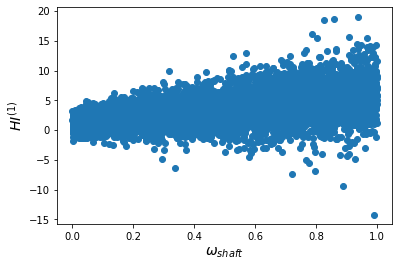

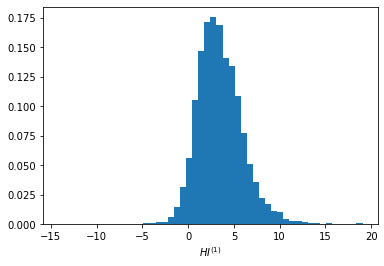

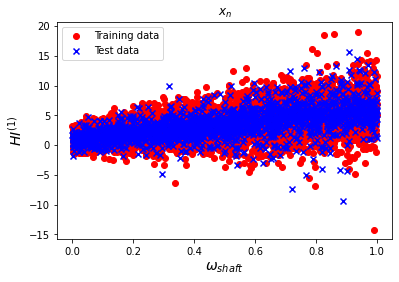

In [70]:
#Datasets
#omega_n, HI_n = linear_sampler(10000)
omega_n, HI_n = linear_shift_sampler(10000)
#omega_n, HI_n = quadratic_sampler(10000)
#HI_n, omega_n  = bishop_sampler(10000)#omega_n, HI_n  = bishop_sampler(10000)#
#omega_n, HI_n = bishop_sampler_2(10000)
#omega_n, HI_n = squared_sampler(10000, sigma = 0.1)

plt.figure()#plt.title(r"$y(x) = 5x + (x^2 \times \epsilon)$")
#plt.title(r"$x_n$")
plt.scatter(omega_n, HI_n) 
plt.xlabel(r"$\omega_{shaft}$", fontsize = 14)
plt.ylabel(r"$HI^{(1)}$", fontsize = 14)
plt.show()

plt.figure()
plt.hist(HI_n, bins = 50, density = True)
plt.xlabel(r"$HI^{(1)}$")
plt.show()

split_frac = 0.8
split_index = int(len(HI_n) * split_frac)

Xtrain, Xtest = omega_n[:split_index], omega_n[split_index:]
Ytrain, Ytest = HI_n[:split_index], HI_n[split_index:]

plt.title(r"$x_n$")
plt.scatter(Xtrain, Ytrain, color = "r", label = "Training data")
plt.scatter(Xtest, Ytest, color = "b", marker = "x", label = "Test data")
plt.xlabel(r"$\omega_{shaft}$", fontsize = 14)
plt.ylabel(r"$HI^{(1)}$", fontsize = 14)
plt.legend()
plt.show()

train_dataset = TensorDataset(torch.from_numpy(Xtrain.astype(np.float32).reshape(-1, 1)), 
                              torch.from_numpy(Ytrain.astype(np.float32).reshape(-1, 1)))

test_dataset = TensorDataset(torch.from_numpy(Xtest.astype(np.float32).reshape(-1, 1)), 
                             torch.from_numpy(Ytest.astype(np.float32).reshape(-1, 1)))

train_dataloader = DataLoader(train_dataset, 
                              batch_size=512, 
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=512, 
                             shuffle=False)

# Initialise the model

In [71]:
n_features = 1
n_components = 10
n_outputs = 1

net_dict = {"ff_layers":[n_features, 25, 25, 25],
            "M":5,
            "learning_rate":5e-3}

model = MixtureDensityNetwork(n_features,
                               n_outputs,
                               n_components, 
                               "network", 
                               net_dict, 
                               init_params = "k-means", 
                               lambda_batch = 0,
                               vectorise = True)

# Train the model

MixtureDensityNetwork(
  (activation): Tanh()
)
Initialisation is not yet implemented as I do not fully understand it.


train cost: 6.557811051607132, valid cost: 2.8367097973823547:   0%|                   | 1/500 [00:00<03:25,  2.43it/s]

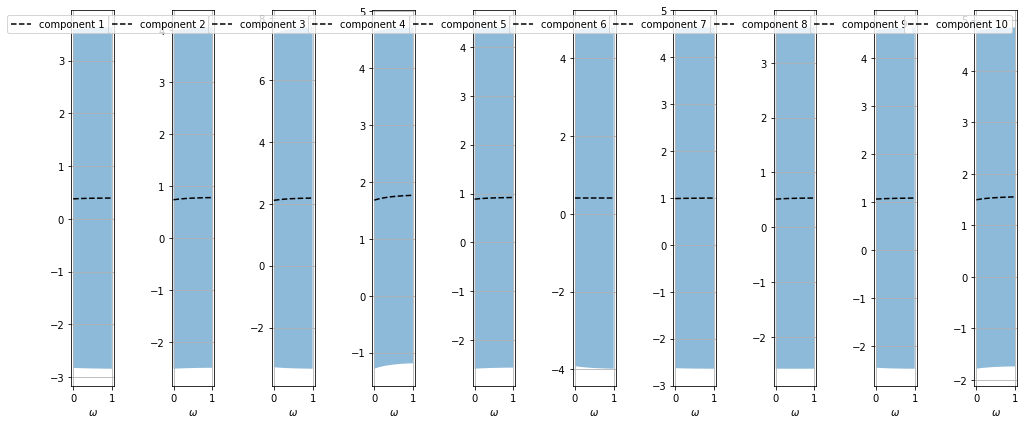

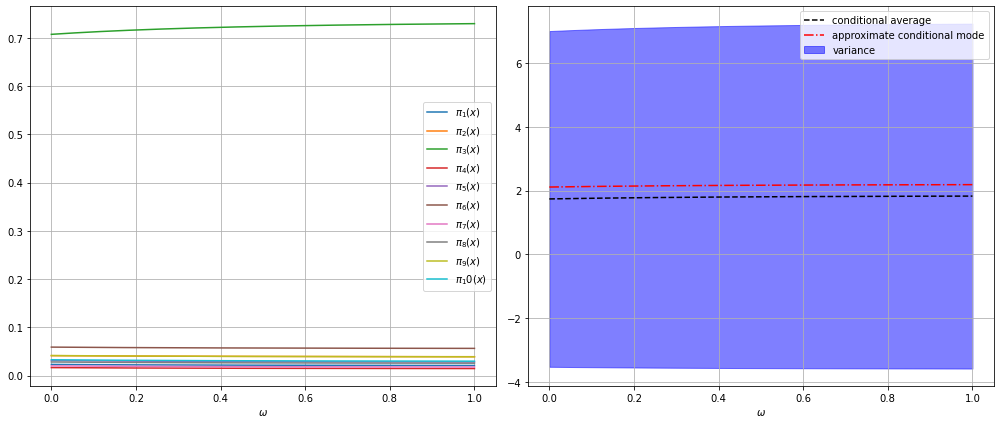

train cost: 1.9817070290446281, valid cost: 1.992362380027771:  10%|█▊                | 51/500 [00:22<03:00,  2.48it/s]

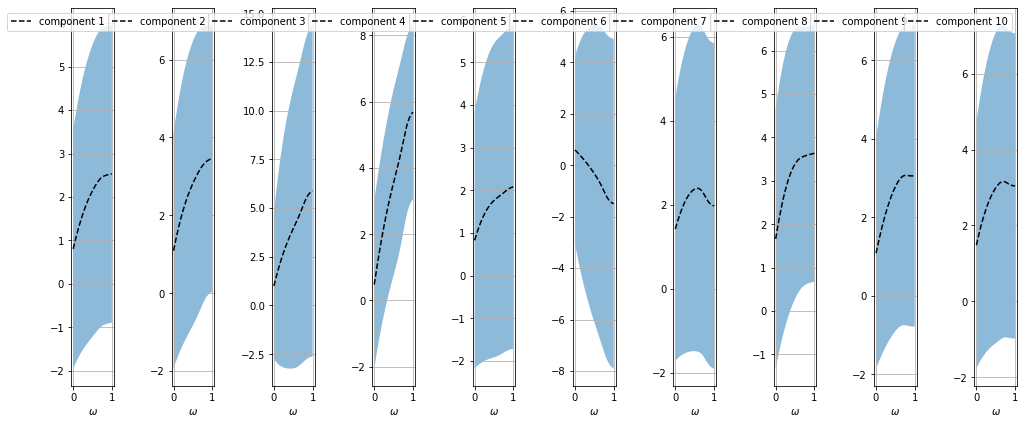

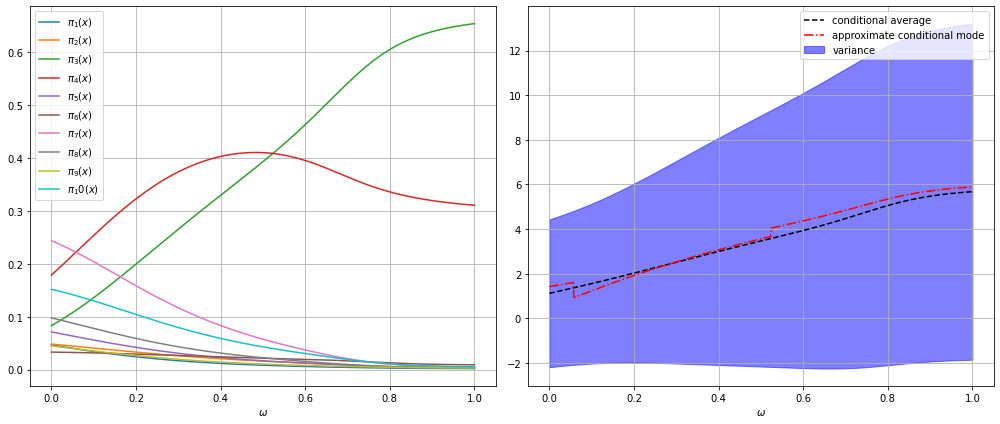

train cost: 1.9786004573106766, valid cost: 1.9887291193008423:  20%|███▏            | 101/500 [00:45<02:54,  2.29it/s]

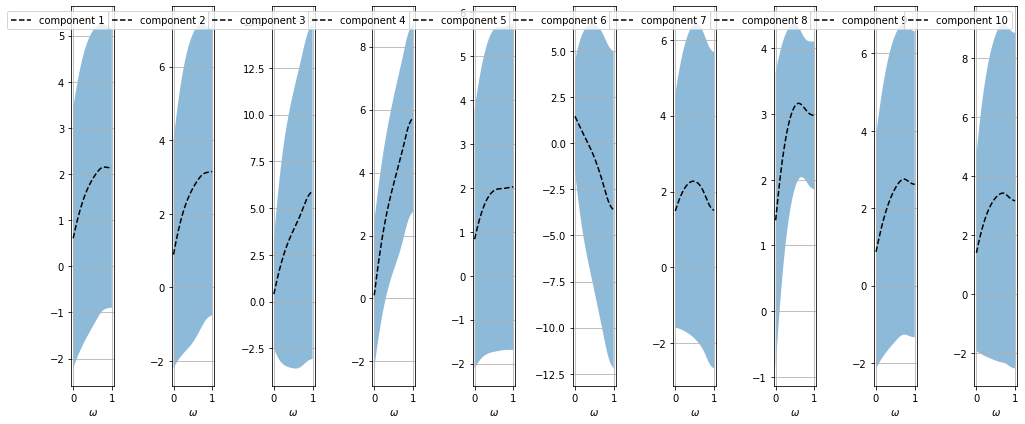

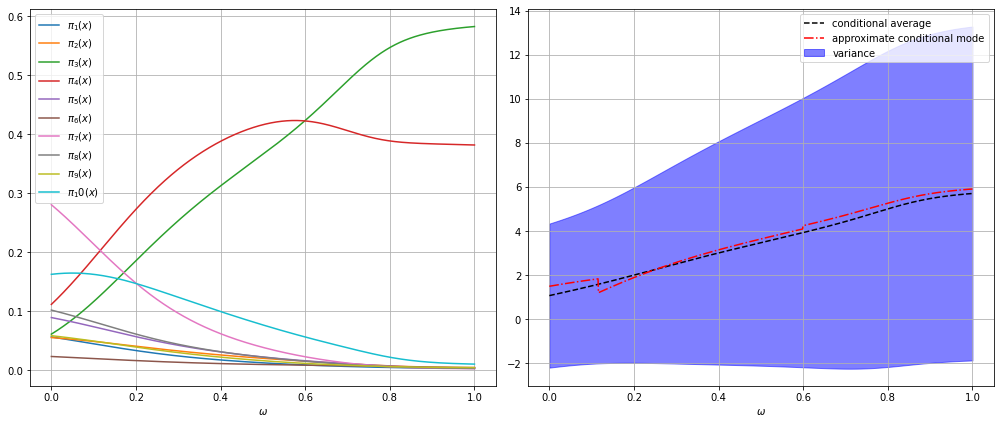

train cost: 1.9791728183627129, valid cost: 1.987968534231186:  30%|█████▏           | 151/500 [01:08<02:23,  2.42it/s]

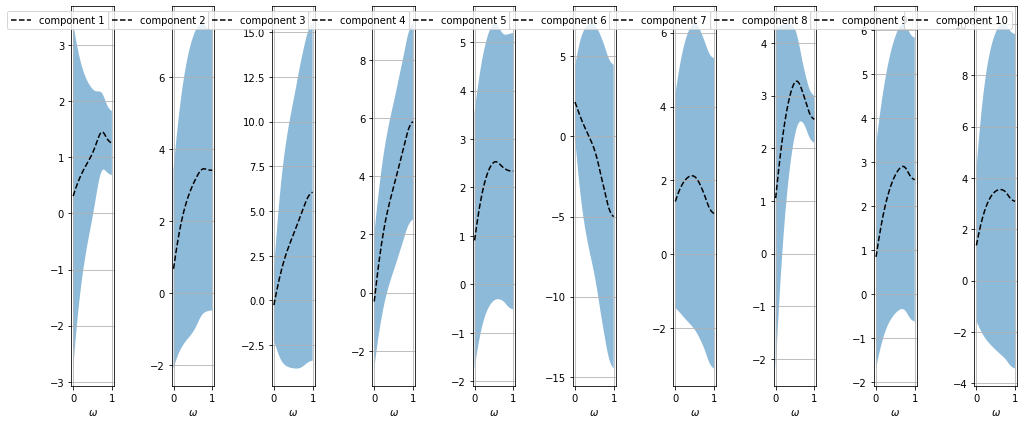

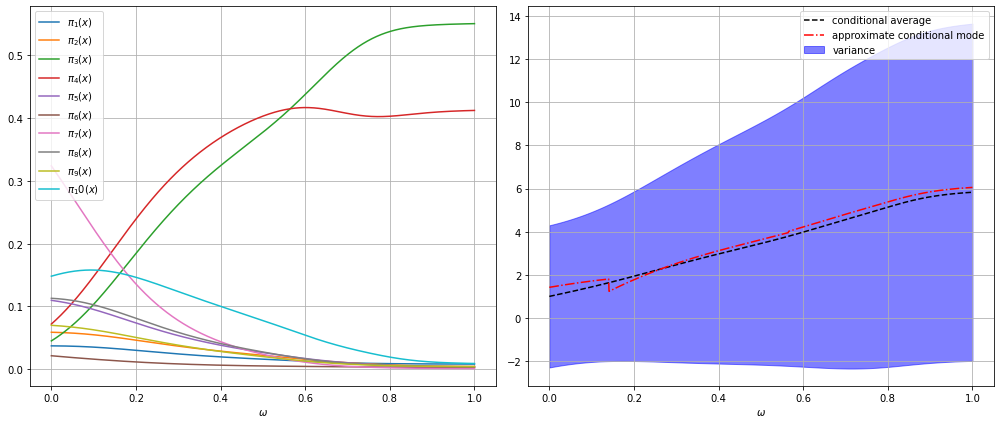

train cost: 1.9795583933591843, valid cost: 1.9913977980613708:  40%|██████▍         | 201/500 [01:30<02:02,  2.45it/s]

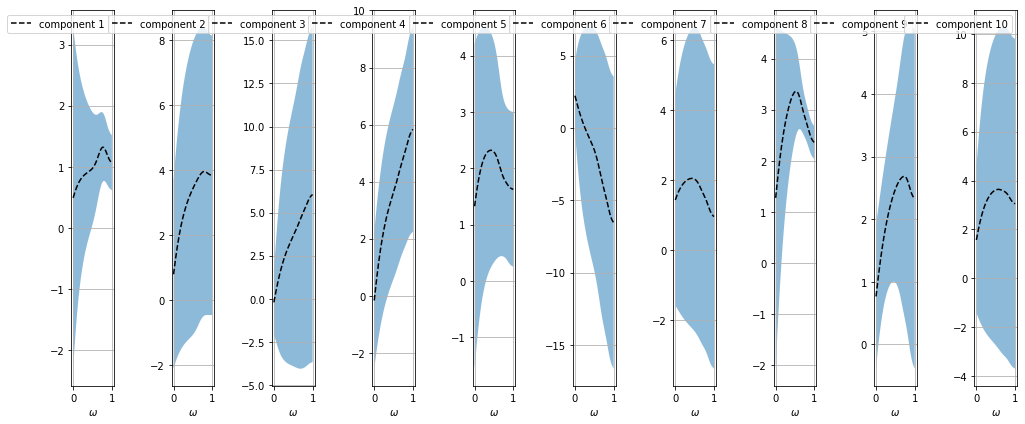

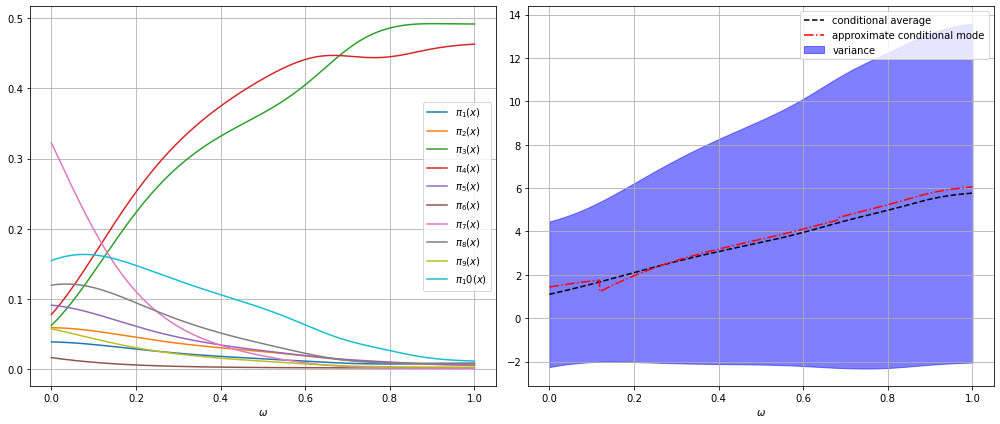

train cost: 1.9794999584555626, valid cost: 1.9910586774349213:  50%|████████        | 251/500 [01:53<01:48,  2.30it/s]

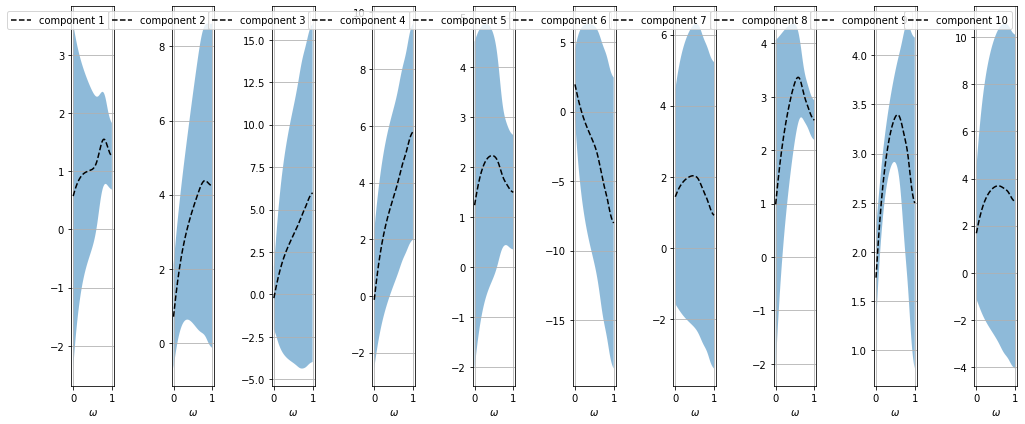

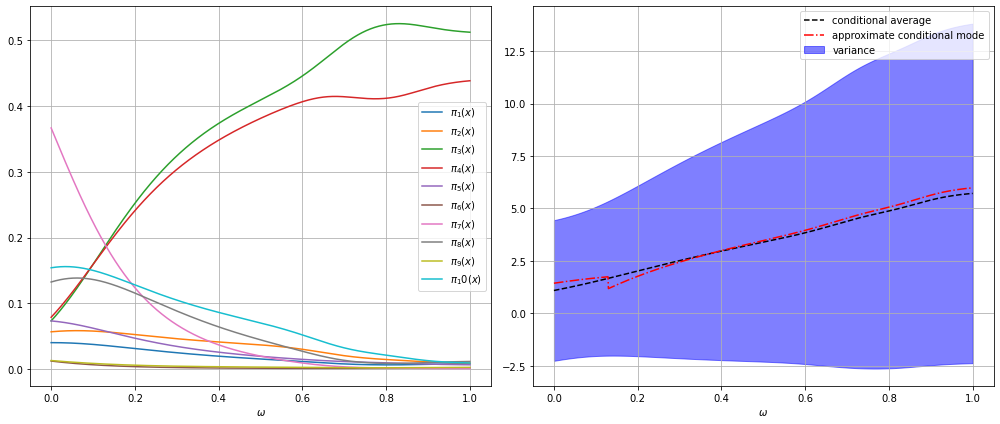

train cost: 1.9771041199564934, valid cost: 1.9932479858398438:  60%|█████████▋      | 301/500 [02:15<01:23,  2.38it/s]

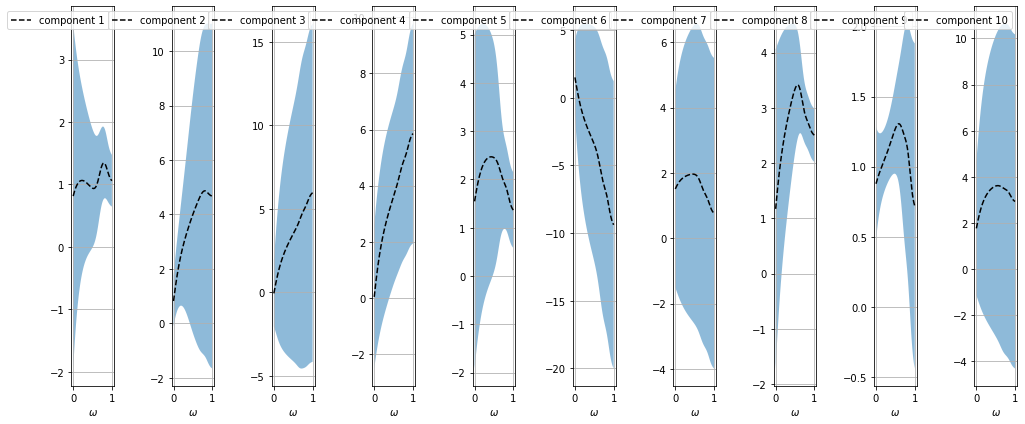

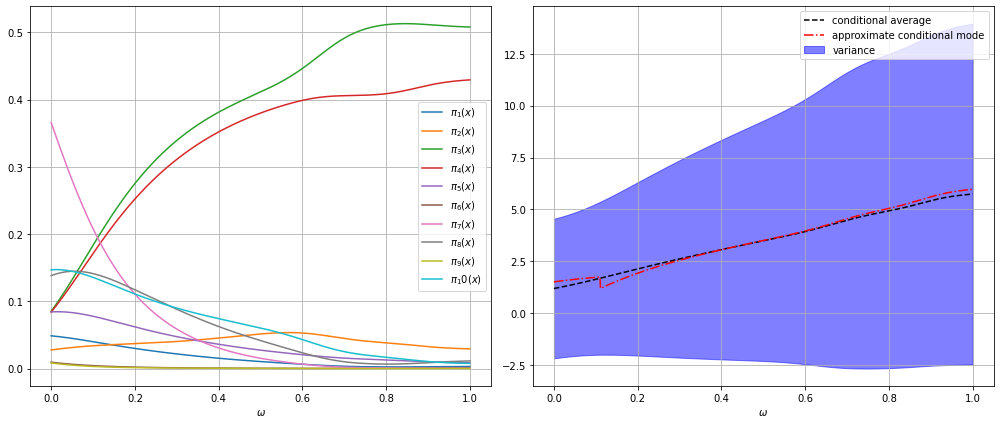

train cost: 1.9757610708475113, valid cost: 1.9898479580879211:  70%|███████████▏    | 351/500 [02:37<01:08,  2.17it/s]

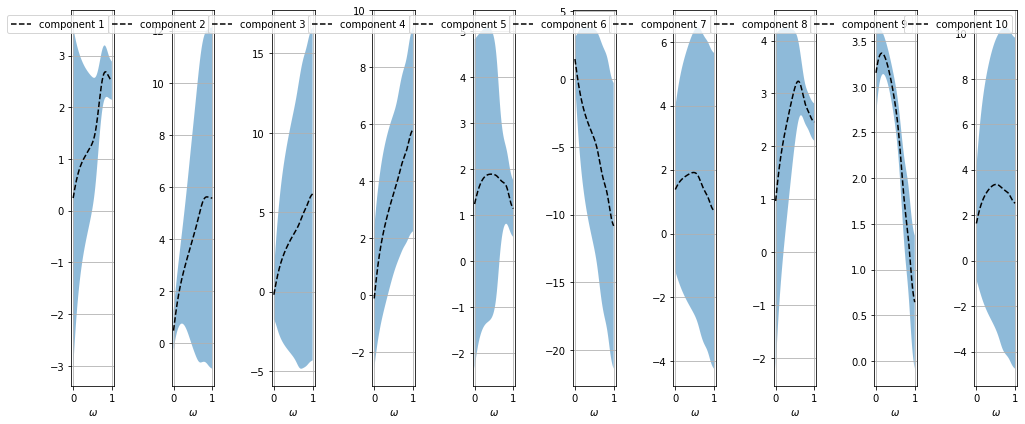

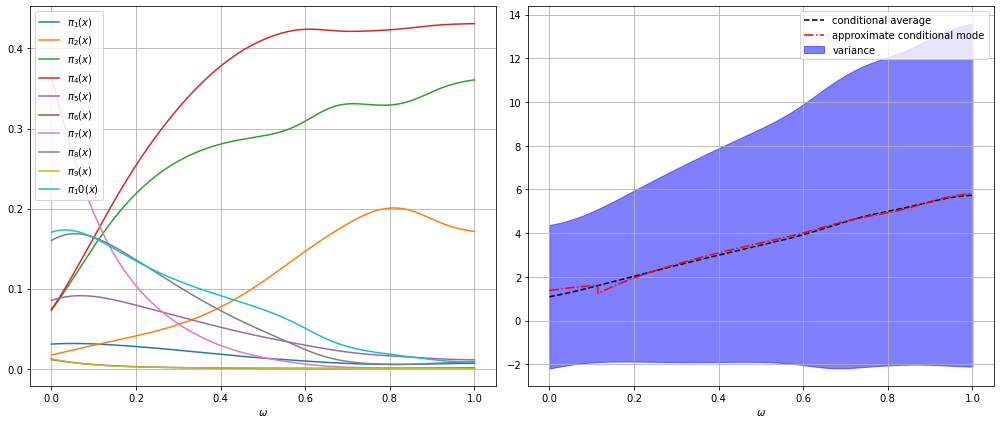

train cost: 1.9747408404946327, valid cost: 1.9917471408843994:  80%|████████████▊   | 401/500 [02:59<00:39,  2.48it/s]

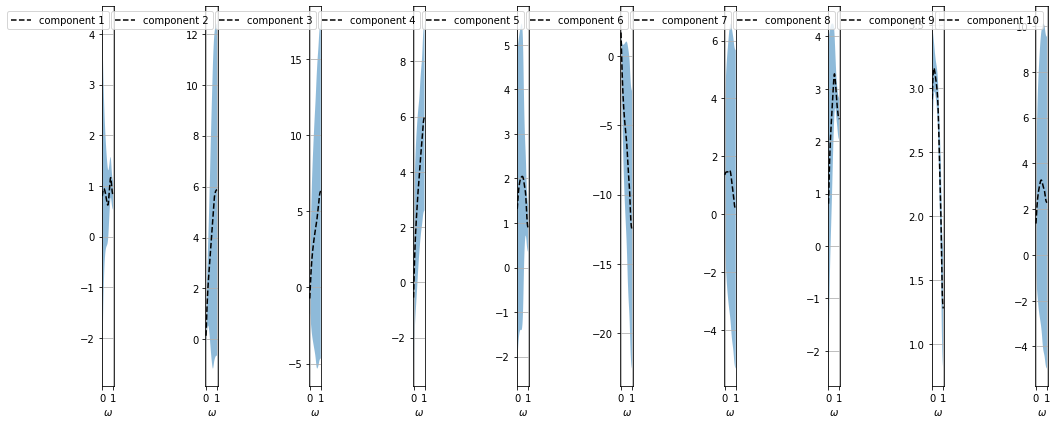

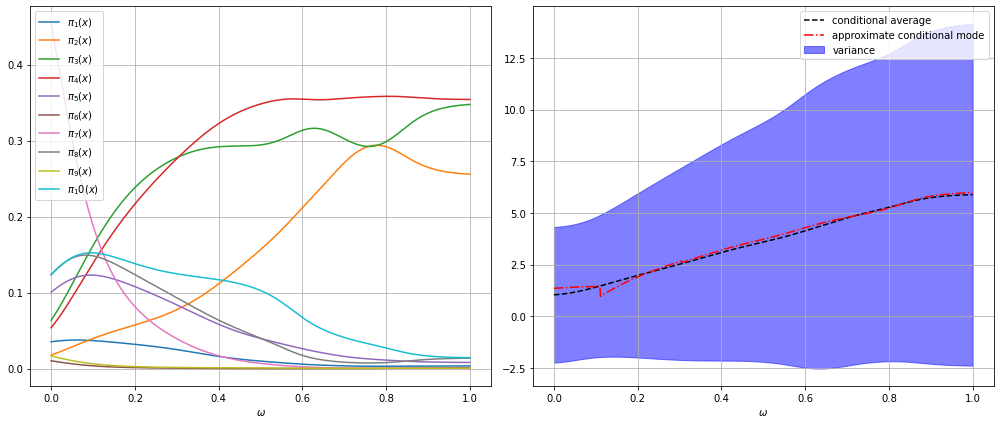

train cost: 1.9745738953351974, valid cost: 1.992740422487259:  90%|███████████████▎ | 451/500 [03:21<00:19,  2.52it/s]

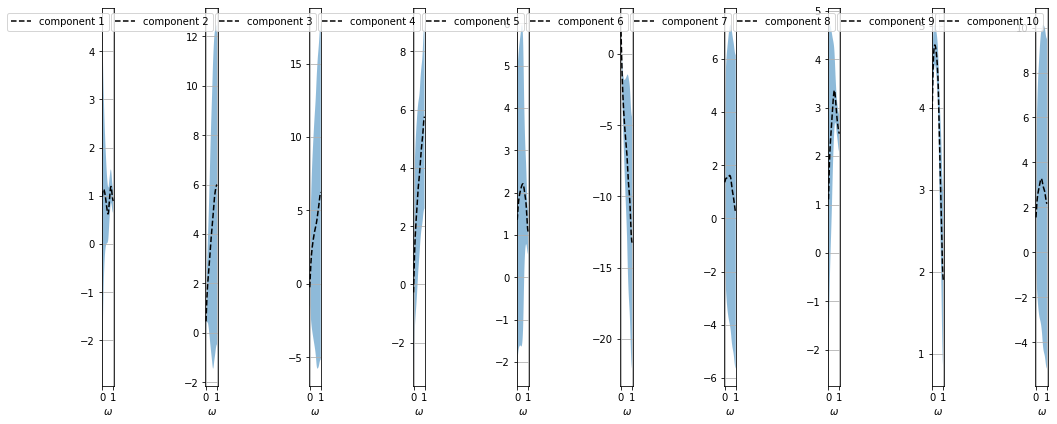

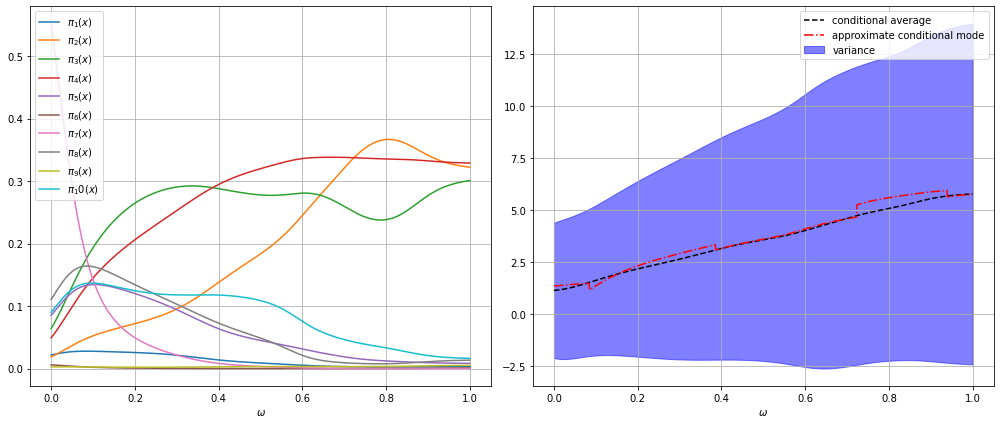

train cost: 1.9770594090223312, valid cost: 1.9918665289878845: 100%|████████████████| 500/500 [03:43<00:00,  2.24it/s]


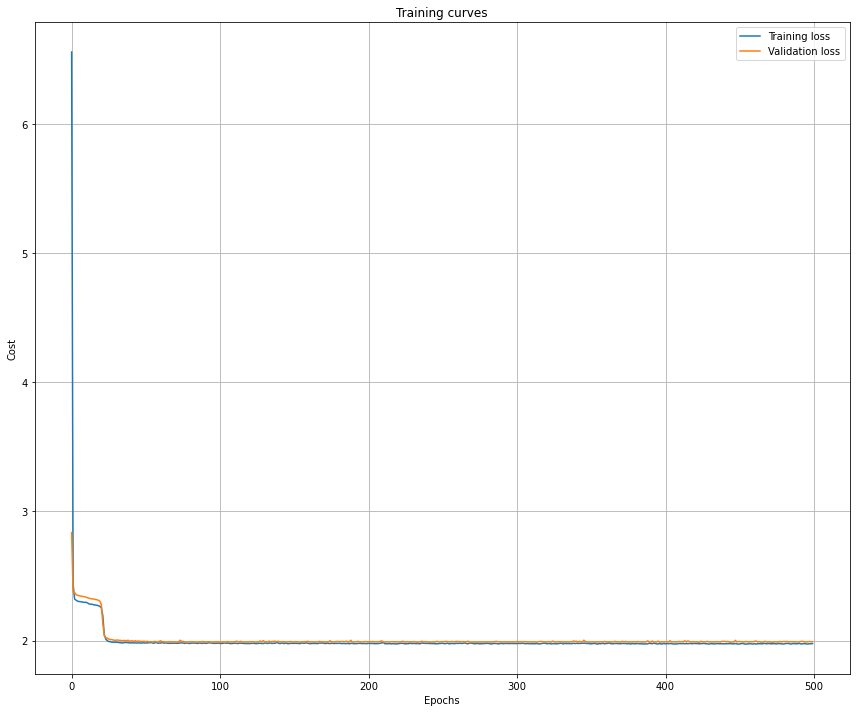

<All keys matched successfully>

In [72]:
print(model)

model.fit(train_dataloader, test_dataloader, 500)
model.plotter()

model.load_state_dict(model.optimal_state_dict)

# Test the model

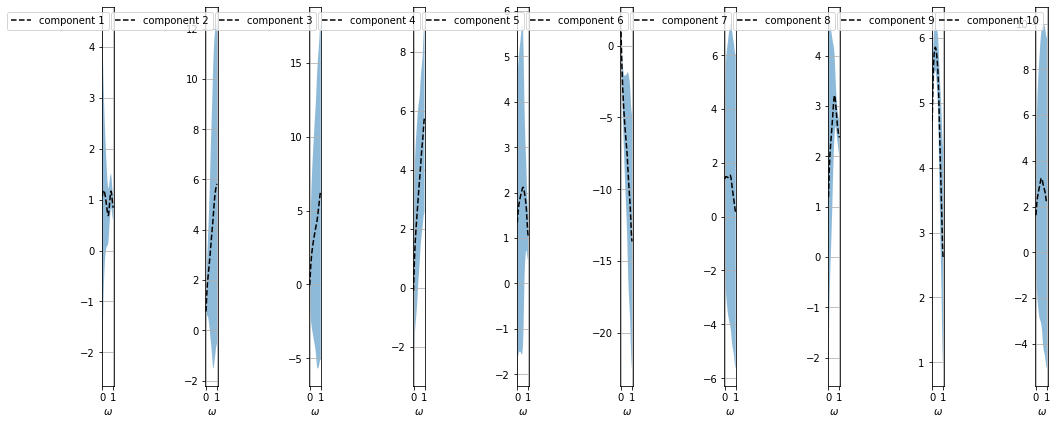

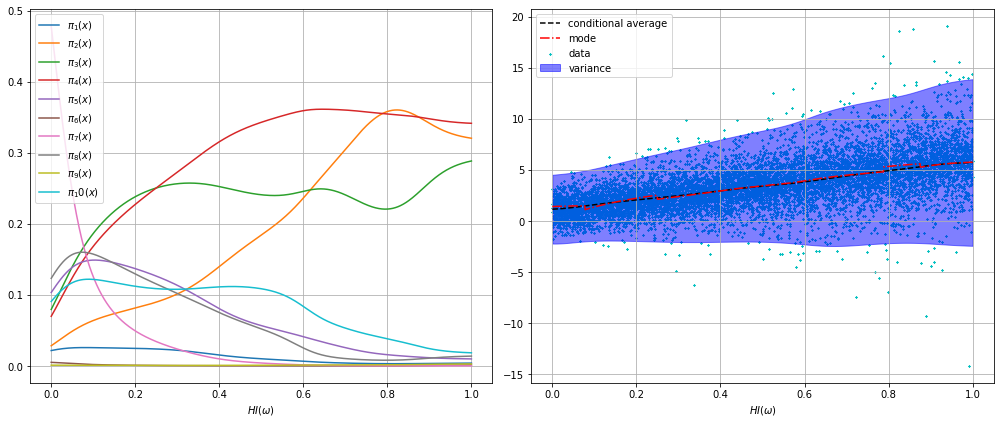

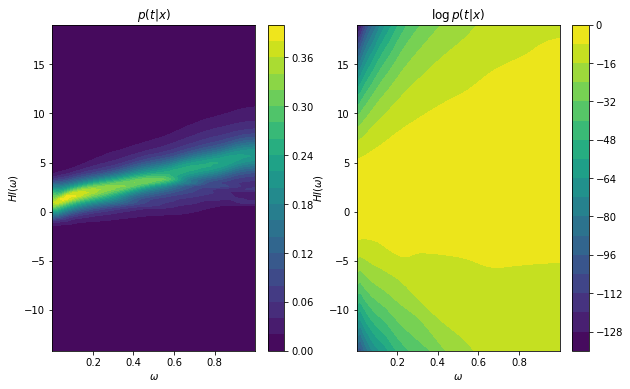

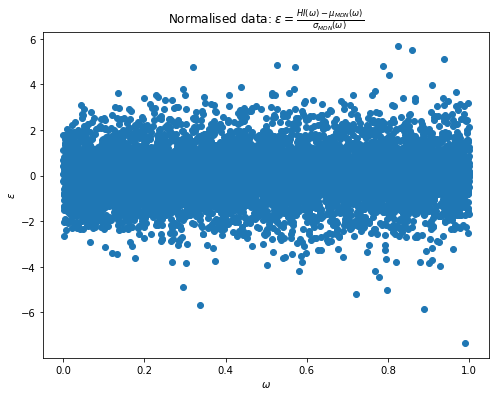

In [73]:
x_range = np.linspace(np.min(omega_n), np.max(omega_n), 1000)
X = torch.from_numpy(x_range.astype(np.float32).reshape(-1, 1)).to(model.device)

with torch.no_grad():
    mu, sigma, pi = model(X)
    
    mean = model.mean(X).detach().cpu().numpy()
    mode = model.mode(X).detach().cpu().numpy()
    variance = model.variance(X).detach().cpu().numpy()
    
    mu = mu.cpu().numpy()
    sigma = sigma.cpu().numpy()
    pi = pi.cpu().numpy()
    mean = mean[:, 0]
    variance = variance[:, 0]
    
    fig, ax = plt.subplots(1, n_components, figsize = (14, 6))
    
    try:
        ax = ax.flatten()
        
    except:
        ax = [ax]
    
    for i in range(mu.shape[1]):
        ax[i].plot(x_range, mu[:, i], "k--", label  = "component {}".format(i + 1))
        ax[i].fill_between(x_range, mu[:, i] - 3 * np.sqrt(sigma[:, i]) , mu[:, i] + 3 * np.sqrt(sigma[:, i]), alpha = 0.5)
    
    for axs in ax:
        axs.grid()
        axs.legend()
        axs.set_xlabel(r"$\omega$")
        
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 6))
    ax = ax.flatten()
    
    for i in range(n_components):
        ax[0].plot(x_range, pi[:, i], label  = r"$\pi_{}(x)$".format(i + 1))
    
    ax[1].plot(x_range, mean, "k--", label  = "conditional average")
    ax[1].plot(x_range, mode, "r-.", label  = "mode")
    ax[1].scatter(omega_n, HI_n, marker = "x", s = 2, c = "c", label = "data") 
    ax[1].fill_between(x_range, mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), color = "b", alpha = 0.5, label = "variance")
    
    for axs in ax:
        axs.grid()
        axs.legend()
        axs.set_xlabel(r"$\omega$")
        axs.set_xlabel(r"$HI(\omega)$")
        
    fig.tight_layout()
    plt.show()
    
    N = 100
    x_range, t_range = np.meshgrid(np.linspace(np.min(omega_n), np.max(omega_n), N), 
                                   np.linspace(np.min(HI_n), np.max(HI_n), N))
    
    X = torch.from_numpy(x_range.astype(np.float32).reshape(-1, 1)).to(model.device)
    T = torch.from_numpy(t_range.astype(np.float32).reshape(-1, 1)).to(model.device)
    
    parameter_tuple = model(X)
    p_t_G_x, _, log_p_t_G_x = model.data_likelihood(T, parameter_tuple)
    
    p_t_G_x = p_t_G_x.cpu().numpy()
    log_p_t_G_x = log_p_t_G_x.cpu().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 6))
    ax = ax.flatten()
    
    ctr = ax[0].contourf(x_range, t_range, p_t_G_x.reshape(N, N), levels = 20)
    fig.colorbar(ctr, ax = ax[0])
    ax[0].set_title("$p(t | x)$")
    
    ctr = ax[1].contourf(x_range, t_range, log_p_t_G_x.reshape(N, N), levels = 20)
    fig.colorbar(ctr, ax = ax[1])
    ax[1].set_title("$\log p(t | x)$")
    
    for axs in ax:
        axs.set_xlabel(r"$\omega$")
        axs.set_ylabel(r"$HI(\omega)$")
        
    plt.show()
    
    x_transform = model.transform_data(torch.from_numpy(omega_n.astype(np.float32).reshape(-1, 1)).to(model.device), 
                                      torch.from_numpy(HI_n.astype(np.float32).reshape(-1, 1)).to(model.device)).cpu().numpy()
    
    plt.figure(figsize = (8, 6))
    plt.title(r"Normalised data: $\varepsilon = \frac{HI(\omega) - \mu_{MDN}(\omega)}{\sigma_{MDN}(\omega)}$")
    plt.scatter(omega_n, x_transform[:, 0])
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\varepsilon$")
    plt.show()
    